## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A company has developed a new web page in order to try to increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 
The goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.
A/B testing technique is to be used to achieve the goal.

<a id='probability'></a>
#### Part I - Probability

In [164]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`Data investigation

a. Read in the dataset and take a look at the top few rows here:

In [165]:
# reading dataset and check top rows:
df = pd.read_csv ('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [166]:
# check dataset volum
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [167]:
df.user_id.nunique()
# about 4000 user_id repeation 

290584

d. The proportion of users converted.

In [168]:
# number of converted unique users / number of unique useres
df.query('converted == 1')['user_id'].nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [169]:
# new_page and treatment don't match count:
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].count()[0]

3893

f. Do any of the rows have missing values?

In [170]:
df.info()
#no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` Data engneering  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [171]:
# replaceing landing page values to new page for the treatment gruop:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]
df2.shape

(290585, 5)

In [172]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Data cleaning  

a. How many unique **user_id**s are in **df2**?

In [173]:
# unique useres:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [174]:
# repeated user id:
df2.user_id.mode()

0    773192
dtype: int64

c. What is the row information for the repeat **user_id**? 

In [175]:
# repeated user info:
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [176]:
df2.shape

(290585, 5)

In [177]:
# Removing repeated user:
drop_index = df2[ df2['user_id'] == 773192 ].index
df2 = df2.drop(drop_index[0]) 

In [178]:
df2.shape

(290584, 5)

`4.` Calculation of probability

a. What is the probability of an individual converting regardless of the page they receive?

In [179]:
# probability of an individual converting regardless of the page they receive
df2[df2['converted'] == 1]['user_id'].count() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [180]:
# control group probability of conversion:
df_control = df2.query('group == "control"')
conversion_control = df_control[df_control['converted'] == 1]['user_id'].count()/ df_control.shape[0]
conversion_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [181]:
# treatment group probability of conversion:
df_treatment = df2.query('group == "treatment"')
conversion_treatment = df_treatment[df_treatment['converted'] == 1]['user_id'].count()/ df_treatment.shape[0]
conversion_treatment

0.11880806551510564

In [182]:
# differnce in conversion probability
conversion_diff = conversion_control - conversion_treatment
conversion_diff

0.0015782389853555567

d. What is the probability that an individual received the new page?

In [183]:
# probability that an individual received the new page
df2[df2['landing_page'] == 'new_page']['user_id'].count() / df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> Users are receiving the new page with almost 50% rate, with a probability of more than 10% of conversion in both treatment and control group.
The differnce between the two conversion propapilities is 0.0016, **there is no statistically significant evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of 

**$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <=0 $$

$$H_1: p_{new} - p_{old} > 0$$

`2.` The following assumptions and steps will be followed to test the hypotheses:

> **Assumption:** <br>Assume under the null hypothesis, 
$p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

> **Steps:**<br>
>>1- Use a sample size for each page equal to the ones in **ab_data.csv**.<br>
>>2- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for
$p_{new}$ under the null? 

In [184]:
# conversion rate under the null:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for 
$p_{old}$ under the null? <br><br>

In [185]:
# Under the null both conversion rates are equal(assumption) about 12%
p_old = 0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [186]:
# sample size of treatment group:
n_new = df2[df2['group'] == "treatment"]['user_id'].nunique() 
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [187]:
# sample size of control group:
n_old = df2[df2['group'] == "control"]['user_id'].nunique() 
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [188]:
#sampling treatment group:
random.seed(42)
new_page_converted = np.random.choice(df2[df2['group']=='treatment']['converted'], size = n_new)
print (new_page_converted)

[0 1 0 ..., 0 0 0]


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [189]:
#sampling control group:
random.seed(42)
old_page_converted = np.random.choice(df2[df2['group']=='control']['converted'], size = n_old)
print (old_page_converted)

[0 0 0 ..., 0 0 0]


g. Find $p_{new}$ - $p_{old}$  for your simulated values from part (e) and (f).

In [190]:
# Difference in conversion rate according to sample:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0021978023029563948

> with this value -almost zero- of differnce we fail to reject the null

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [191]:
# Random sampling for conversions of each group :

p_diffs = []

n_new = df2[df2['group'] == "treatment"]['user_id'].nunique() 
n_old = df2[df2['group'] == "control"]['user_id'].nunique()

new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

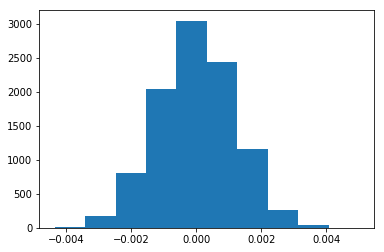

In [192]:
# plotting the conversions' differnce:
plt.hist(p_diffs);


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

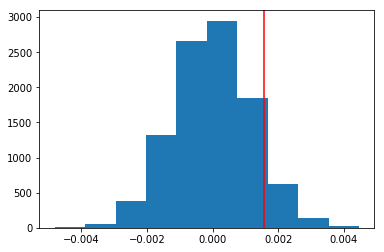

In [193]:
# simulate the distribution under the null hypothesis

p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# plot null distribution
plt.hist(null_vals);

# plotting p-value by finding the proportion of values in the null distribution that were greater than our observed difference
# plot line for observed statistic
plt.axvline(conversion_diff, c='red');


In [194]:
# compute p value

p_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
(null_vals > p_diff).mean()

0.91080000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**Conclusion**<br>
>>With p-value 0.9, it seems that our statistics is from this null, we *fail to reject the null Hypotheses*.<br>
We can't recommend launching the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [195]:
from statsmodels.stats.proportion import proportions_ztest

# control group conversions:
df_control = df2.query('group == "control"')
convert_old = df_control[df_control['converted'] == 1]['user_id'].count()

# treatment group conversions:
df_treatment = df2.query('group == "treatment"')
convert_new = df_treatment[df_treatment['converted'] == 1]['user_id'].count()

# size of both samples:
n_new = df2[df2['group'] == "treatment"]['user_id'].nunique() 
n_old = df2[df2['group'] == "control"]['user_id'].nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [196]:
# number of successes
counts = np.array([convert_old,convert_new])
# number of trials:
nobs = np.array([n_old, n_new])
# p value:
stat, pval = proportions_ztest(counts, nobs)
print('stat: ', stat, '\n', 'pval', pval)

stat:  1.31092419842 
 pval 0.189883374482


**Conclusion**

> If we assume that we want a 95% confidance level of the test. the z score is 1.3 then the p-value of 0.19  dosn't fall in the rejection area, That means that we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` Logistic linear regrission:

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> we are predicting categorical data with only 2 outcomes: conversion or not conversion. so, logistics regression model should be used.

**b.** See if there is a significant difference in conversion based on which page a customer receives.

In [197]:
# Creating crosponding dummy variables for group and landing page columns
df2[['new_page', 'old_page']]= pd.get_dummies(df2['landing_page'])
df2[['control', 'ab_page']]= pd.get_dummies(df2['group'])

#adding intercept column
df2['intercept'] =1

df2 = df2.drop(['old_page','control'], axis = 1)
df2.head(5)

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1


c. Fiting regression model on the two columns intercept, ab_page. to predict whether or not an individual converts. 

In [198]:
import statsmodels.api as sm
from scipy import stats

# regression model using ab_page and new_page columns:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. model summary:

In [199]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 10:17 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

** Conclusion**

> p-Value for ab_page is 0.19, it is > 0.0025 thus we fail to reject the null hypothesis. 
the following hypothesis:
The Hypothesis under the null is : There is no significant difference in conversion based on which page a customer receives
The alternative is: There is a significant difference in conversion based on which page a customer receives

> value differs from the value I found in part II because part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> It gives us more the information available to estimate the dependent variable. Its also enable us to fit curves not only line.

> New variables might be correlated to existing variables and this affect the regression results."Multicollinearity"

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

In [200]:
# reading data from new file:
df_country = pd.read_csv('countries.csv')
df_country.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [201]:
# joining the two data sets in a new one df3:
df3 = df2.join(df_country.set_index('user_id'), on ='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,US


In [202]:
# Creating crosponding dummy variables for country
df3[['CA', 'UK', 'USA']]= pd.get_dummies(df3['country'])
df3 = df3.drop('USA', axis =1)
df3['CA_new'] = df3['CA'] * df3['ab_page']
df3['UK_new'] = df3['UK'] * df3['ab_page']

df3.head(10)

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept,country,CA,UK,CA_new,UK_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,US,0,0,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,0,1,US,0,0,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,CA,1,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,0,1,US,0,0,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,UK,0,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,CA,1,0,1,0


In [203]:
# regression model using countries columns:
# Null hypothesis : country has no impact on conversion
# Alternative : country has an impact on conversion

lm = sm.Logit(df3['converted'], df3[['intercept', 'CA_new', 'UK_new']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 10:17 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_new       -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_new        0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

** Conclusion**
> Being a Canadian is less effective of being from USA (base line) by 0.07 while being from UK positively affect by 0.015

> p-Values associated with being from USA is 0.0, that shows statisticall significant

> p-Values associated with being a canedian is 0.046 less than 0.05, that shows statisticall significant

> p-Values associated with being from UK is 0.39 more than 0.05, that shows no statisticall significant


> two of the three countries show statistical significant effect on conversion that might suggest that country have effect on conversion.

h. Look at an interaction between page and country to see if there significant effects on conversion. 

In [206]:
# regression model using all varaibles: Landing page, group and country
# Null hypothesis : variables have no impact on conversion
# Alternative : variables have an impact on conversion

lm = sm.OLS(df3['converted'], df3[['intercept', 'CA_new', 'UK_new', 'ab_page']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.351
Date:                Wed, 14 Oct 2020   Prob (F-statistic):             0.0702
Time:                        10:18:22   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
CA_new        -0.0066      0.004     -1.669      0.095      -0.014       0.001
UK_new         0.0027      0.002      1.361      0.173      -0.001       0.007
ab_page       -0.0019      0.001     -1.449      0.147      -0.005       0.001
==============================================================================
Omnibus:                   125549.632   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414287.274
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         7.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

** Conclusion **
>p-Value for all variables are > 0.05, thus we fail to reject the null hypothesis of the following hypothesis:<br>
<br>Null hypothesis: variables have no impact on conversion
<br>Alternative: variables have an impact on conversion

>So, we fail to reject the null hypothesis.and we don't recommend lounching the new page

In [205]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0